In [1]:
# Make sure you are running under a virtual environment
! pip install -r requirements.txt

  Using cached gdown-5.1.0-py3-none-any.whl.metadata (5.7 kB)
  Using cached pandas-2.2.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (19 kB)
  Using cached matplotlib-3.8.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cassandra_driver-3.29.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.9 kB)
  Using cached folium-0.16.0-py2.py3-none-any.whl.metadata (3.6 kB)
  Using cached kaggle-1.6.6-py3-none-any.whl
  Using cached beautifulsoup4-4.12.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
  Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (114 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.2

In [7]:
import os 
import gdown

if not os.path.exists('data'):
    os.makedirs('data')
    gdown.download("https://drive.google.com/file/d/1pX6eLIK1kYzqSpbx-uTL6GuywHPhd1TE/view?usp=drive_link",
                   "data/tweets.zip", fuzzy=True)
    ! cd data && unzip tweets.zip

TWEETS_CSV = 'data/tweets.csv'

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

## Task 1

At first we attempted to use Twitter API, but the free access was too limited and therfore blocked us from fetching tweets using the API:

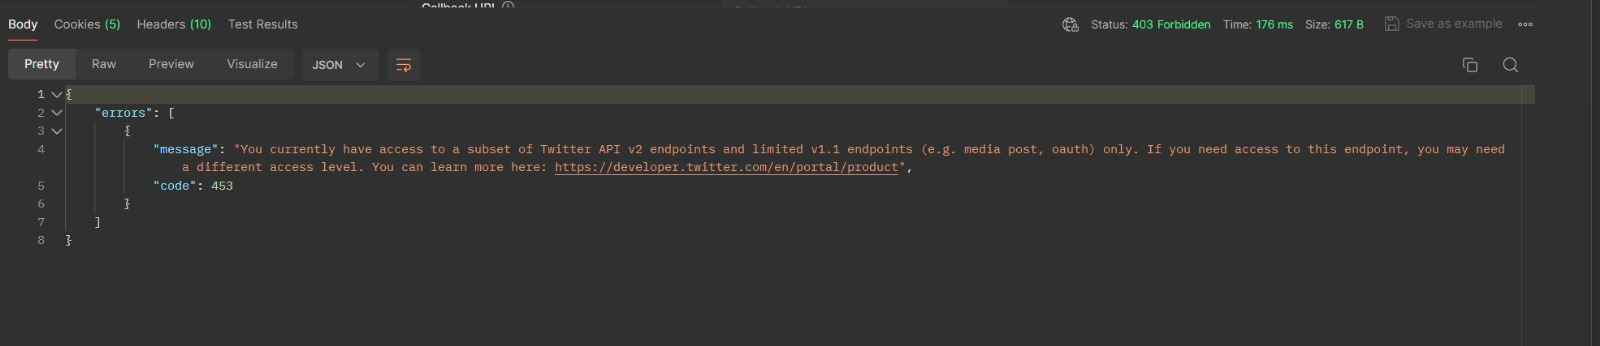

As an alternative, we opted to use the suggested Kaggle dataset.

The dataset source can be found here:
https://www.kaggle.com/datasets/mmmarchetti/tweets-dataset


In [10]:
tweets=pd.read_csv(TWEETS_CSV)
tweets.head()

,author,content,country,date_time,id,language,latitude,longitude,number_of_likes,number_of_shares
0,katyperry,Is history repeating itself...?#DONTNORMALIZEH...,NaN,12/01/2017 19:52,8.196330e+17,en,NaN,NaN,7900,3472
1,katyperry,@barackobama Thank you for your incredible gra...,NaN,11/01/2017 08:38,8.191010e+17,en,NaN,NaN,3689,1380
2,katyperry,Life goals. https://t.co/XIn1qKMKQl,NaN,11/01/2017 02:52,8.190140e+17,en,NaN,NaN,10341,2387
3,katyperry,Me right now 🙏🏻 https://t.co/gW55C1wrwd,NaN,11/01/2017 02:44,8.190120e+17,en,NaN,NaN,10774,2458
4,katyperry,SISTERS ARE DOIN' IT FOR THEMSELVES! 🙌🏻💪🏻❤️ ht...,NaN,10/01/2017 05:22,8.186890e+17,en,NaN,NaN,17620,4655


## Task 2 - Kubernetes Cluster Configuration

## Task 3 - Data Ingestion and Processing

In order to allow for insightful analysis in an efficient manner, we decided to create a pre-structured dataset that corresponds to the insights that we plan to offer.

The insights the engine will offer:

* Most popular hashtags by year
* Most popular author by year
* Correlation between hashtag and number of likes / shares
* Correlation between number of likes and number of shares
* Graph of mentions given author
* Emoji histogram
* Most used emoji given author

### Hashtags

- **Table Name**: `hashtag_stats`
- **Primary Key**:, 
  - **Partition Key**: `tag_name`
  - **Clustering Key**: `date_time`
- **Columns**:
  - `date_time` (timestamp)
  - `tag_name` (text)
  - `number_of_likes` (int)
  - `number_of_shares` (int)
  - `country` (text)
  - `latitude` (float)
  - `longitude` (float)

### Author Popularity

- **Table Name**: `authors_stats`
- **Primary Key**:, 
  - **Partition Key**: `author_name`
  - **Clustering Key**: `date_time`
- **Columns**:
  - `date_time` (timestamp)
  - `author_name` (text)
  - `number_of_likes` (int)
  - `number_of_shares` (int)
  - `country` (text)
  - `latitude` (float)
  - `longitude` (float)

### User Mentions

- **Table Name**: `user_mention`
- **Primary Key**:, 
  - **Partition Key**: `user_name, mention_name`
  - **Clustering Key**: `date_time`
- **Columns**:
  - `date_time` (timestamp)
  - `user_name` (text)
  - `mention_name` (text)

### Emoji Stats

- **Table Name**: `emoji_stats`
- **Primary Key**:, 
  - **Partition Key**: `emoji, author`
  - **Clustering Key**: `date_time`
- **Columns**:
  - `date_time` (timestamp)
  - `emoji` (text)
  - `author` (text)
  - `number_of_likes` (int)
  - `number_of_shares` (int)
  - `country` (text)
  - `latitude` (float)
  - `longitude` (float)

In [12]:
# Kill any running previous instance
! docker kill my_kusto || echo true

# Setting up cassandra instance using docker with local persistent storage under the persistent_data folder.
# The cassandra.yaml file is also mounted to the container to allow for configuration changes.
# ! docker run --rm -d --name my_cassandra -p 9042:9042 -v `pwd`/cassandra.yaml:/etc/cassandra/cassandra.yaml -v `pwd`/persistent_data:/var/lib/cassandra cassandra 
! docker run --rm -e ACCEPT_EULA=Y -m 4G -d --name my_kusto -p 8080:8080 -v `pwd`/persistent_data:/kustodata -t mcr.microsoft.com/azuredataexplorer/kustainer-linux:latest


Error response from daemon: Cannot kill container: my_cassandra: No such container: my_cassandra
true
Unable to find image 'cassandra:latest' locally
latest: Pulling from library/cassandra

b86eb9ec: Pulling fs layer 
8895d27e: Pulling fs layer 
2608df3c: Pulling fs layer 
01f729b6: Pulling fs layer 
772dc20b: Pulling fs layer 
1604764f: Pulling fs layer 
b5c15dfe: Pulling fs layer 
c2362a4f: Pulling fs layer 
6b0ecc50: Pulling fs layer 
Digest: sha256:2e53494bf88d2474ad17364e3cb3b38f3a724e0a866c90b09c5e10b8f3509b61
Status: Downloaded newer image for cassandra:latest
64cf19c36133522c4228816f6d86c006e7be73eed381590eb461f11eda30a6ab


In [17]:
from cassandra.cluster import Cluster
from cassandra.query import BatchStatement
from cassandra.query import SimpleStatement

# Setup Cassandra Connection
cluster = Cluster(['127.0.0.1'])
session = cluster.connect()

In [19]:
# Create Keyspace and Tables

if 'BatchStatement' in locals():
    session.execute("DROP KEYSPACE IF EXISTS twitter_insights")

if 'Cluster' in locals():
    session.execute("""
        CREATE KEYSPACE IF NOT EXISTS twitter_insights WITH replication = {
            'class': 'SimpleStrategy', 'replication_factor': '3'
        }
    """)

    session.set_keyspace('twitter_insights')

    session.execute("""
        CREATE TABLE IF NOT EXISTS hashtag_stats (
            date_time timestamp,
            year int,
            tag_name text,
            number_of_likes int,
            number_of_shares int,
            country text,
            latitude float,
            longitude float,
            PRIMARY KEY (tag_name, year, date_time)
        );
    """)

    session.execute("""
        CREATE TABLE IF NOT EXISTS author_stats (
            date_time timestamp,
            author_name text,
            number_of_likes int,
            number_of_shares int,
            country text,
            latitude float,
            longitude float,
            PRIMARY KEY (author_name, date_time)
        );
    """)

    session.execute("""
        CREATE TABLE IF NOT EXISTS emoji_stats (
            date_time timestamp,
            emoji text,
            author text,
            number_of_likes int,
            number_of_shares int,
            country text,
            latitude float,
            longitude float,
            PRIMARY KEY ((emoji, author), date_time)
        );
    """)


In [20]:
# Setting the batch size so that we can control the number of rows inserted per batch
batch_size = 1024*25 # 25KB

In [21]:
import re

# Create individual insert statements
insert_authors_popularity = session.prepare(
    f"INSERT INTO author_stats (date_time, author_name, number_of_likes, number_of_shares) "
    f"VALUES (?, ?, ?, ?)"
)
insert_hashtag_stats = session.prepare(
    f"INSERT INTO hashtag_stats (date_time, year, tag_name, number_of_likes, number_of_shares) "
    f"VALUES (?, ?, ?, ?, ?)"
)
insert_emoji_stats = session.prepare(
    f"INSERT INTO emoji_stats (date_time, emoji, author, number_of_likes, number_of_shares) "
    f"VALUES (?, ?, ?, ?, ?)"
)

def extract_hashtags(tweet):
    # Define the regex pattern for hashtags
    hashtag_pattern = r'#\w+'

    # Find all hashtags in the tweet
    hashtags = re.findall(hashtag_pattern, tweet)

    return hashtags

def extract_emojis(tweet):
    # Define the regex pattern for emojis
    emoji_pattern = r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF]'

    # Find all emojis in the tweet
    emojis = re.findall(emoji_pattern, tweet, flags=re.UNICODE)

    return emojis

# Ingestion of tweets
batch = BatchStatement()
for index, row in tweets.iterrows():
    # Extract data from the CSV row
    date_time = pd.to_datetime(row['date_time'])
    author_name = row['author']
    number_of_likes = int(row['number_of_likes'])
    number_of_shares = int(row['number_of_shares'])
    content = row['content']
    # Note: Current dataset includes empty geo fields, ignoring them for this calculation.
    # country = row['country']
    # latitude = float(row['latitude'])
    # longitude = float(row['longitude'])

    # Insert data into author_stats table
    batch.add(
        insert_authors_popularity,
        (date_time, author_name, number_of_likes, number_of_shares)
    )

    # Insert data into hashtag_stats table
    hashtags = extract_hashtags(content)
    for hashtag in hashtags:
        batch.add(
            insert_hashtag_stats,
            (date_time, date_time.year, hashtag, number_of_likes, number_of_shares)
        )

    # Insert data into emoji_stats table
    emojis = extract_emojis(content)
    for emoji in emojis:
        batch.add(
            insert_emoji_stats,
            (date_time, emoji, author_name, number_of_likes, number_of_shares)
        )

    if index % batch_size == 0:
        session.execute(batch)
        batch.clear()

session.execute(batch)


/var/folders/z5/943hwd2x4_l4y18g9y1tc8dr0000gn/T/ipykernel_12030/2488258634.py:39: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  date_time = pd.to_datetime(row['date_time'])


# Task 4 - Data Analysis and Insight Extraction

Execute these two commands, in order to start a cqlsh session within our cassandra container, which allows us to run CQL commands directly against your Cassandra database.

Starting a `cqlsh` session on the instance:
`docker exec -it my_cassandra cqlsh`

Applying the keyspace:
`use twitter_insights`

Query1: Most Popular Hashtags by Year:
To find the most popular hashtags by year, we can aggregate the number of likes or shares for each hashtag and sort them in descending order.

```SQL
SELECT tag_name, SUM(number_of_likes) AS total_likes, SUM(number_of_shares) AS total_shares
FROM hashtag_stats
GROUP BY tag_name
ORDER BY total_likes DESC
LIMIT 10
ALLOW FILTERING;
```

Most Popular Author by Year:
Similar to hashtags, we can aggregate the number of likes or shares for each author and sort them.
Example query (assuming authors_popularity table):
SQL

SELECT author_name, SUM(number_of_likes) AS total_likes
FROM authors_popularity
WHERE date_time >= '2024-01-01' AND date_time < '2025-01-01'
GROUP BY author_name
ORDER BY total_likes DESC
LIMIT 1;
AI-generated code. Review and use carefully. More info on FAQ.
Correlation between Hashtag and Likes/Shares:
To find the correlation, we can calculate the correlation coefficient between the number of likes and shares for each hashtag.
Example query (assuming hashtag_stats table):
SQL

SELECT CORR(number_of_likes, number_of_shares) AS correlation
FROM hashtag_stats
WHERE tag_name = 'your_hashtag';
AI-generated code. Review and use carefully. More info on FAQ.
Correlation between Likes and Shares:
Similar to hashtags, we can calculate the correlation coefficient between the number of likes and shares globally.
Example query (assuming hashtag_stats table):
SQL

SELECT CORR(number_of_likes, number_of_shares) AS global_correlation
FROM hashtag_stats;
AI-generated code. Review and use carefully. More info on FAQ.
Graph of Mentions Given Author:
To create a graph of mentions, we need to traverse the data based on the author’s name and their mentions.
Example query (assuming user_mention table):
SQL

SELECT mention_name
FROM user_mention
WHERE user_name = 'your_author';
AI-generated code. Review and use carefully. More info on FAQ.
Emoji Histogram:
To create an emoji histogram, we count the occurrences of each emoji in the data.
Example query (assuming emoji_stats table):
SQL

SELECT emoji, COUNT(*) AS frequency
FROM emoji_stats
GROUP BY emoji
ORDER BY frequency DESC;
AI-generated code. Review and use carefully. More info on FAQ.
Most Used Emoji Given Author:
Similar to hashtags and authors, we can find the most used emoji by a specific author.
Example query (assuming emoji_stats table):
SQL

SELECT emoji, SUM(number_of_likes) + SUM(number_of_shares) AS total_interactions
FROM emoji_stats
WHERE author = 'your_author'
GROUP BY emoji
ORDER BY total_interactions DESC
LIMIT 1;

## Question 5

In [33]:
rows = session.execute("""
SELECT tag_name, SUM(number_of_likes) AS total_likes, SUM(number_of_shares) AS total_shares
FROM hashtag_stats
GROUP BY tag_name
LIMIT 10
ALLOW FILTERING;
""")

pd.DataFrame(list(rows))

,tag_name,total_likes,total_shares
0,#TheUncommonThread,24943,11705
1,#WorkBxxchVideoTomorrow,4222,6561
2,#EnterSandman,1369,308
3,#londoniloveyou,14859,16777
4,#VMAafterparty,961,1102
5,#WHPresolutions,5256,1094
6,#TS1989,1636063,749016
7,#AUS,3170,1287
8,#ThereISaidIt,13426,5040
9,#1989touratlanta,41098,16410


In [22]:
rows = session.execute("""
SELECT tag_name, SUM(number_of_likes) AS total_likes, SUM(number_of_shares) AS total_shares
FROM hashtag_stats
GROUP BY tag_name
ORDER BY total_likes DESC
LIMIT 10
ALLOW FILTERING;
""")

df = pd.DataFrame(list(rows))

# Ignore noise and irrelevant measurments 
df_filtered = df[df['average_value'] != -1]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df_filtered['measurement_date'], df_filtered['average_value'], marker='o', linestyle='None', color='b')
plt.title('Average Value of Pollutant Over Time in 2019 (Without -1 Values)')
plt.xlabel('Date')
plt.ylabel('Average Value')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

InvalidRequest: Error from server: code=2200 [Invalid query] message="Undefined column name total_likes in table twitter_insights.hashtag_stats"

<Figure size 1000x600 with 0 Axes>

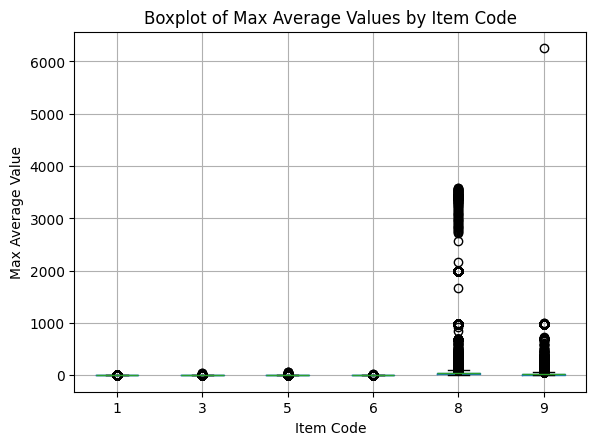

In [35]:
# Calculate the maximum average_value for each combination of station_code, item_code, measurement_date
rows = session.execute("""
SELECT item_code, MAX(average_value) AS max_average_value
FROM measurement_joined
GROUP BY station_code, item_code, measurement_date
""")

df = pd.DataFrame(rows)

plt.figure(figsize=(10, 6))
# This visualization provides a clear summary of the range and distribution of the maximum average values for each item code
# In the boxplot, the central line represents the median value, the edges of the box are the 25th and 75th percentiles
df.boxplot(column='max_average_value', by='item_code', grid=True)

plt.title('Boxplot of Max Average Values by Item Code')
plt.suptitle('') 
plt.xlabel('Item Code')
plt.ylabel('Max Average Value')

plt.show()

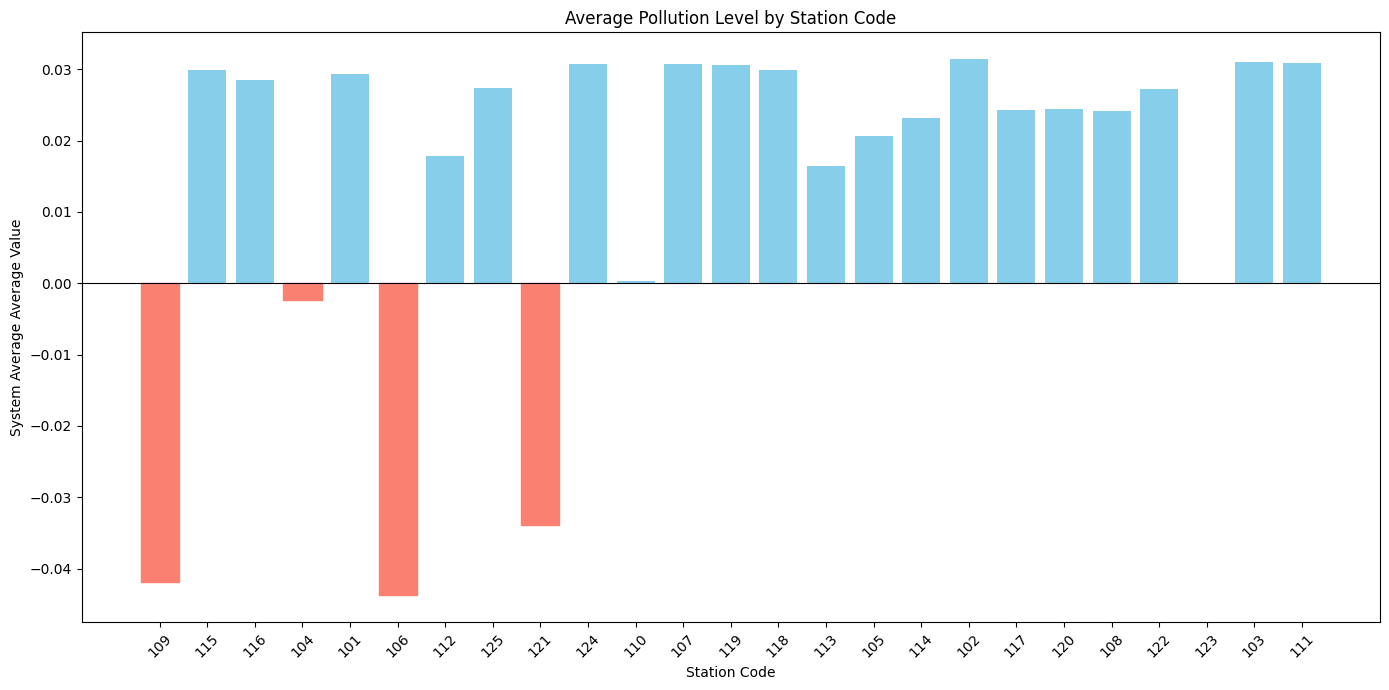

In [36]:
# Calculate the average average_value pollution Level for a specific pollutant for each station_code in a date limit
rows = session.execute("""
SELECT station_code, item_code, AVG(average_value) 
FROM measurement_joined 
WHERE item_code = 3 AND measurement_date >= '2019-01-01 00:00:00' AND measurement_date <= '2019-12-01 00:00:00'
GROUP BY station_code, item_code
ALLOW FILTERING;
""")
df = pd.DataFrame(rows)

# Plotting a bar plot for the average average_value for each station_code
plt.figure(figsize=(14, 7))
bars = plt.bar(df['station_code'].astype(str), df['system_avg_average_value'], color='skyblue')

# Adding a horizontal line at y=0 for reference
plt.axhline(0, color='black', linewidth=0.8)

# Highlight negative average values in a different color
for bar in bars:
    if bar.get_height() < 0:
        bar.set_color('salmon')

plt.title('Average Pollution Level by Station Code')
plt.xlabel('Station Code')
plt.ylabel('System Average Average Value')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [37]:
# Count the measurements exceeding a threshold for a specific pollutant
rows = session.execute("""
SELECT COUNT(*)
FROM measurement_joined 
WHERE item_code = 6 AND average_value > 0.7
ALLOW FILTERING;
""")
print(pd.DataFrame(list(rows)))

   count
0     11


In [38]:
# Get the latest measurement date of a specific pollutant 
rows = session.execute("""
SELECT MAX(measurement_date) as latest_date
FROM measurement_joined
WHERE item_code = 3
ALLOW FILTERING;
""")
print(pd.DataFrame(list(rows)))

          latest_date
0 2019-12-31 23:00:00


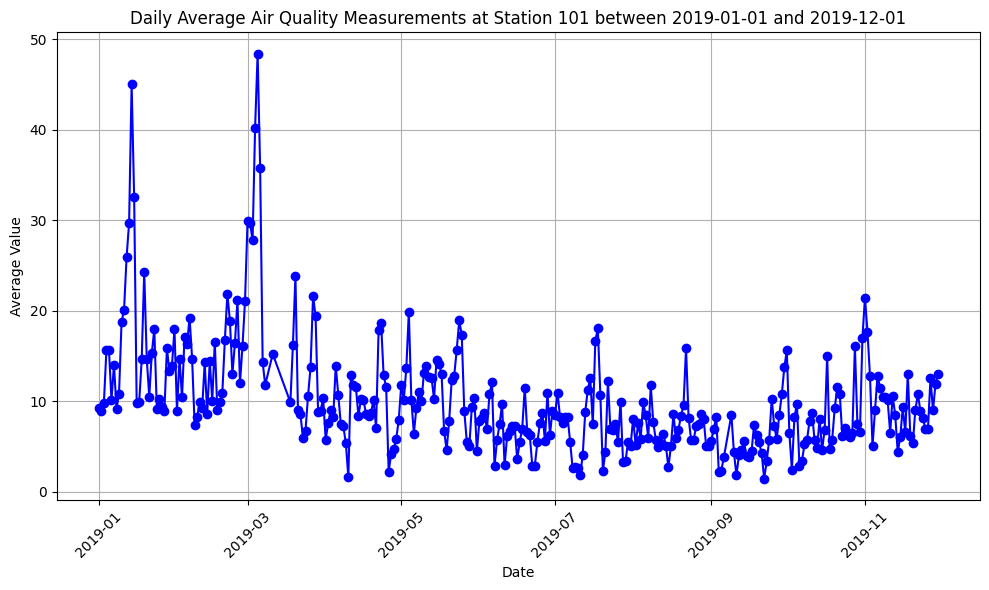

In [39]:
# Query daily average air quality measurements at station 101 between 2019-01-01 and 2019-12-01
query = """
SELECT measurement_date, average_value FROM measurement_joined 
WHERE station_code = 101 AND measurement_date >= '2019-01-01 00:00:00' 
AND measurement_date < '2019-12-01 00:00:00'
ALLOW FILTERING;
"""
statement = SimpleStatement(query, fetch_size=None)
rows = session.execute(statement)
df = pd.DataFrame(list(rows))

# Convert measurement_date to a date (without time) for daily aggregation
df['measurement_date'] = pd.to_datetime(df['measurement_date']).dt.date

# Aggregate by date to get daily average
daily_avg = df.groupby('measurement_date')['average_value'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(daily_avg['measurement_date'], daily_avg['average_value'], marker='o', linestyle='-', color='b')
plt.title('Daily Average Air Quality Measurements at Station 101 between 2019-01-01 and 2019-12-01')
plt.xlabel('Date')
plt.ylabel('Average Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlapping
plt.show()

In [40]:
# Showcase a map with all the locations where a specific pollutant item was viewed
query = """
SELECT latitude, longitude
FROM measurement_joined 
WHERE item_code = 6
ALLOW FILTERING;
"""

rows = session.execute(query)

unique_coordinates = set()

# Iterate through the rows and filter out duplicates
for row in rows:
    lat_lon = (row.latitude, row.longitude)
    unique_coordinates.add(lat_lon)

# Calculate the map center
map_center = [
    sum(lat for lat, lon in unique_coordinates) / len(unique_coordinates),
    sum(lon for lat, lon in unique_coordinates) / len(unique_coordinates),
]

m = folium.Map(location=map_center, zoom_start=12)

# Add markers for unique coordinates
for coord in unique_coordinates:
    folium.Marker(location=coord, popup=str(coord)).add_to(m)

display(m)

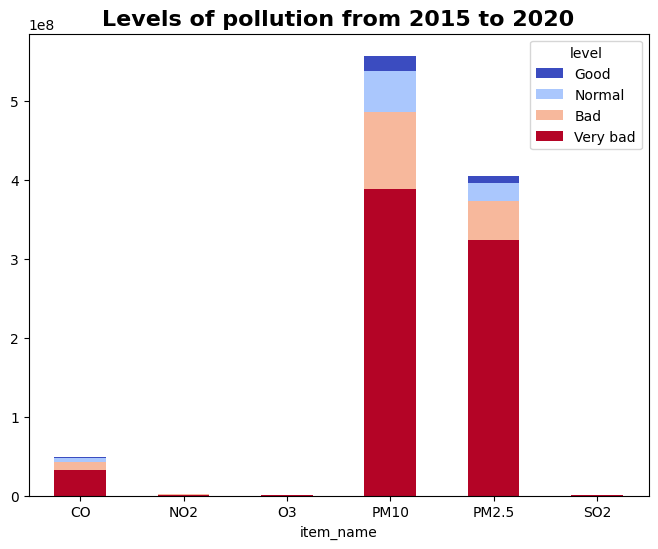

In [41]:
# Showcase the level of pollution for each item, between 2015 to 2020 relative on the different pollution levels
rows = session.execute("""
SELECT item_name, good_blue, normal_green, bad_yellow, very_bad_red
FROM measurement_joined 
WHERE measurement_date >= '2015-01-01 00:00:00' 
  AND measurement_date <= '2020-12-31 23:59:59'
  ALLOW FILTERING;
""")
df = pd.DataFrame(rows)

categories = {
    "good_blue": "Good",
    "normal_green": "Normal",
    "bad_yellow": "Bad",
    "very_bad_red": "Very bad"
}

# Reshaping the data to have a single column for level and value
df_melted = df.melt(id_vars=["item_name"], var_name="level", value_name="value")
df_melted["level"] = df_melted["level"].map(categories)

# Counting the number of occurrences for each pollution level and item
level_counts = df_melted.groupby(["item_name", "level"])["value"].sum().unstack()

level_counts = level_counts[['Very bad', 'Bad', 'Normal', 'Good']]

ax = level_counts.plot(kind='bar', stacked=True, figsize=(8,6), rot=0,
                       colormap='coolwarm_r', legend='reverse')
plt.title('Levels of pollution from 2015 to 2020', fontsize=16, fontweight='bold')
plt.show()